In [120]:
%matplotlib inline
import csv
import numpy as np
from numpy import ma
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tnrange, tqdm_notebook
import igraph as ig
import louvain
from graph_tool.all import *
from sklearn import linear_model
from sklearn.model_selection import LeaveOneOut 

### This is required when we are using matplotlib and openmp (for graph-tool) together in one run of jupyter
### to make it more weird, it only happens in macOS
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### Loading assigned blocks in the paper results

In [103]:
chiMeta = pd.read_csv('data/chilean_metadata.csv')

In [104]:
chiMeta.head()

Spec           Species names  BodyMass sessile/mobile  Cluster  \
0     1       acanthina monodon      8.00              M        4   
1     2      acanthocyclus gayi      6.01              M        1   
2     3  acanthocyclus hassleri      6.65              M        1   
3     4  acanthopleura echinata      5.10              M        7   
4     5  chaetopleura peruviana      0.18              M        7   

  Shore Height 1 conservative  ShoreHt_C_Ordinal  ShoreHt_C_Breadth  \
0                    mid, low                1.5                  2   
1                    mid, low                1.5                  2   
2                    mid, low                1.5                  2   
3                         low                1.0                  1   
4                         low                1.0                  1   

  Shore Height 2 restrictive  ShoreHt_R_Ordinal  ShortHt_R_Breadth  \
0                        low                1.0                  1   
1                   mid, low                1.5                  2   
2                        mid                2.0                  1   
3                        low                1.0                  1   
4                        low                1.0                  1   

      Phyllum      subphyllum    trophic  
0    Mollusca      Gastropoda   Predator  
1  Arthropoda       Crustacae   Predator  
2  Arthropoda       Crustacae   Predator  
3    Mollusca  Polyplacophora  Herbivore  
4    Mollusca  Polyplacophora  Herbivore

## Running SBM using iGraph

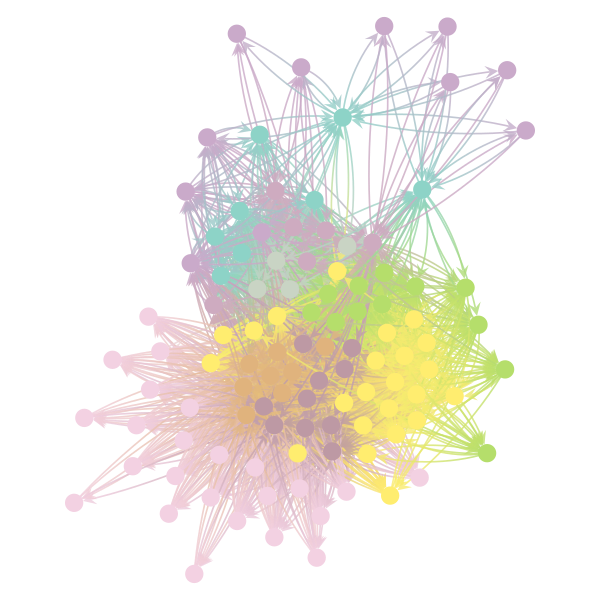

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x1a5a3fd940, at 0x1a5ab04b70>

In [105]:
# implementing with graph tool
g = Graph()
g.add_edge_list(np.transpose(AS.nonzero()))
state = minimize_blockmodel_dl(g)
blocks = state.get_blocks()
state.draw()

### Prerequisite Functions and Initializations

In [106]:
# constructing adj matrix
n = 0
A = []
with open('data/chilean_TI.txt') as f:
    reader = csv.reader(f, delimiter='\t')
    for i, line in enumerate(reader):
        if i == 0:
            continue
        A.append(line[2:])
n = len(A)  # number of nodes
A = np.asarray(A).astype(int)
AS = np.array([[(A[i][j] | A[j][i]) & (i != j) for i in range(n)] for j in range(n)])
deg = np.sum(A, axis=1)
degsym = np.sum(AS, axis=1)

In [107]:
def gen_classAdjMatrix(q, a, n, Q, row, eps):
    V = np.array([[1 * (a[i] == c) for i in range(n)] for c in range(Q)])  # q,n matrix
    R = V @ AS @ V.T  # q,q matrix
    R = R * (np.ones((Q, Q)) - 0.5 * np.identity(Q))
    e = np.sum(R, axis=1)  # q vector
    num = np.sum(V, axis=1)  # q vector
    yqr = (row @ V.T) @ ((R[q] + eps) / (e + eps * Q))  # /sum(row)
    outer = np.outer(num, num)
    mat = np.divide(R, outer, out=np.zeros_like(R), where=outer!=0)
#     mat = R / outer
    x = mat * ma.log(mat)
    x = x.filled(0)
    xcomp = (1 - mat) * ma.log(1 - mat)
    xcomp = xcomp.filled(0)
    H = -( x + xcomp )
    S = np.sum(outer * H)  
    return S, yqr, e

### Running MCMC to get the local optima of the blocks
And later
### Choose the number of clusters that maximizes the provided likelihood-based equation

We ran the MCMC algorithm along with the loop over different number of blocks (clusters) multiple times.
The range for the number of blocks that would maximize the likelihood-based equation provided in the homework varied from 7 to 10 and it was "*8*" in most of the trials.

The class membership probability distribution of our implementation is provided in the next cell for one of the runs

In [113]:
# our implementation
# Q number of classes
def get_for_q(Q):
    eps = 70
    beta = 1
    K = 100  # number of iterations
    nSquared_log = np.log(n * (n - 1))
    n_log = np.log(n)
    a = np.random.randint(Q, size=n)  # classes of each node
    at = np.zeros((n, Q))
    # iterations
    for k1 in tqdm_notebook(range(K), leave=False):
        for i in range(n):
            row = AS[i]
            rand = np.random.randint(degsym[i])
            j = [x for x in enumerate(row) if x[1] == 1][rand][0]
            q, t = a[i], a[j]
            S1, yqr, e = gen_classAdjMatrix(q, a, n, Q, row, eps) # if you print the values of S1 here, they are decreasing
            r = np.random.randint(Q)
            et = e[t]
            rt = eps * Q / (et + eps * Q)
            accept = np.random.rand() < rt
            if not accept:
                ctn = [x for x in enumerate(a) if x[1] == t]
                rand = np.random.randint(len(ctn))
                v = ctn[rand][0]
                r = a[v]
            a[i] = r
            # did it for all and not just neighbors
            S2, xqr, e = gen_classAdjMatrix(r, a, n, Q, row, eps)           
            S = (S2 - S1) / 2
            rand = np.random.rand()
            p = min(np.exp(-beta * S) * xqr / yqr, 1)
            if np.isnan(S2):
                p = 0
            if rand > p:
                a[i] = q
        for h in range(n):
            at[h][a[h]] += 1
    V = np.array([[1 * (a[u] == c) for u in range(n)] for c in range(Q)])  # q,n matrix
    R = V @ AS @ V.T  # this is different from previous R
    e = np.sum(R, axis=1)  # q vector
    num = np.sum(V, axis=1)  # q vector
    p_matrix = (at.T / np.sum(at, axis=1)).T  # this is n,Q probability matrix
    alpha = np.sum(p_matrix, axis=0)  # q number vector
    theta = R / (np.outer(num, num))
    Rpart = R * ma.log(theta)
    Rpart = Rpart.filled(0)
    RcomplementPart = (1 - R) * ma.log(1 - theta)
    RcomplementPart = RcomplementPart.filled(0)
    L2 = Rpart + RcomplementPart
    alpha_log = np.log(alpha)
#     alpha_log = alpha_log.filled(-np.inf)
    L = num @ alpha_log + 0.5 * np.sum(L2) \
        - 0.5 * (Q * (Q + 1) * nSquared_log / 2 - (Q - 1) * n_log)
    block_assignments = np.argmax(at, axis=1)

    return p_matrix, block_assignments, L


pmmax, bamax, Lmax, Qmax = 0, 0, - np.inf, 0
for i in tqdm_notebook(range(2, 15)):
    pm, ba, L = get_for_q(i)
    print('block:{}, ll:{}'.format(i, L))
    if L > Lmax:
        pmmax, bamax, Lmax, Qmax = pm, ba, L, i
probMat, blockAssignment, ll = get_for_q(Qmax)
print('The best number of clusters based on the max likelihood achieved is: {}'.format(Qmax))
print('The max likelihood is: {}'.format(ll))
print('The probability matrix showing soft assignment of the nodes:')
print(probMat)
print('The hard assignment of nodes based on maximum probability:')
print(blockAssignment)

block:2, ll:-937.5260291671059


block:3, ll:-1012.9279595047625


block:4, ll:-366.0379235150384


block:5, ll:2638.985975231183


block:6, ll:-110.35680035218215


block:7, ll:1369.2918505298617


block:8, ll:3115.5705454265662


block:9, ll:1936.736386710494


block:10, ll:1999.456220926448


block:11, ll:2468.030843941929


block:12, ll:2245.7504104081495


block:13, ll:1427.3972637313223


block:14, ll:1536.6349325558224



The best number of clusters based on the max likelihood achieved is: 8
The max likelihood is: 2902.725797308812
The probability matrix showing soft assignment of the nodes:
[[0.01 0.   0.   0.   0.99 0.   0.   0.  ]
 [0.   0.   0.   0.   0.53 0.47 0.   0.  ]
 [0.   0.01 0.   0.   0.74 0.25 0.   0.  ]
 [0.   0.   0.65 0.3  0.   0.01 0.   0.04]
 [0.   0.   0.98 0.   0.01 0.01 0.   0.  ]
 [0.   0.   0.98 0.02 0.   0.   0.   0.  ]
 [0.   0.   0.92 0.06 0.02 0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.01 0.   0.81 0.   0.   0.   0.18]
 [0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.98 0.   0.   0.   0.   0.02]
 [0.   0.   0.86 0.14 0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.91 0.09 0.   0.   0.   0.  ]
 [0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.99 0.   0.01 0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.91 0.   0.   0.   0.09]
 [0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0. 

### How the result compares with the one in the paper?
As said earlier, most of the range of number of clusters is always smaller than total number of clusters reported in the paper, although in both cases the SBM model is being used.

The main explanation here is the multi-layer blocking method the authors have used in the paper to specifically and intentionally separate different groups of species as quoted below:
```
1. trophic level category (autotroph, herbivore, intermediate, top), 
2. mobility (mobile versus sessile), 
3. and shore height (ordinal)
```
These categories are very well predicted by simple species attributes.

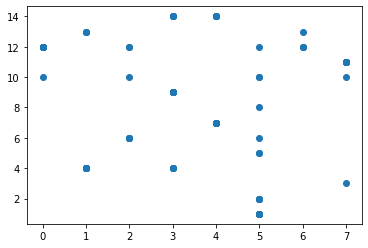

In [49]:
plt.scatter(blockAssignment, chiMeta['Cluster'])

### Louvain selected as the non-probabilistic modularity method

Clustering with 106 elements and 3 clusters
[0] 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 26, 29, 30, 31, 32, 33, 39, 41, 42, 43,
    44, 46, 47, 48, 49, 50, 53, 54, 55, 56, 57, 58, 62, 63, 64, 65, 67, 69,
    72, 73, 77, 80, 82, 84, 85, 86, 87, 88, 91
[1] 0, 1, 2, 8, 9, 18, 19, 20, 21, 23, 27, 34, 35, 36, 38, 40, 60, 61, 66, 68,
    70, 71, 75, 76, 81, 90, 94, 95, 96, 100, 101, 102, 103, 104
[2] 15, 16, 17, 22, 24, 25, 28, 37, 45, 51, 52, 59, 74, 78, 79, 83, 89, 92,
    93, 97, 98, 99, 105


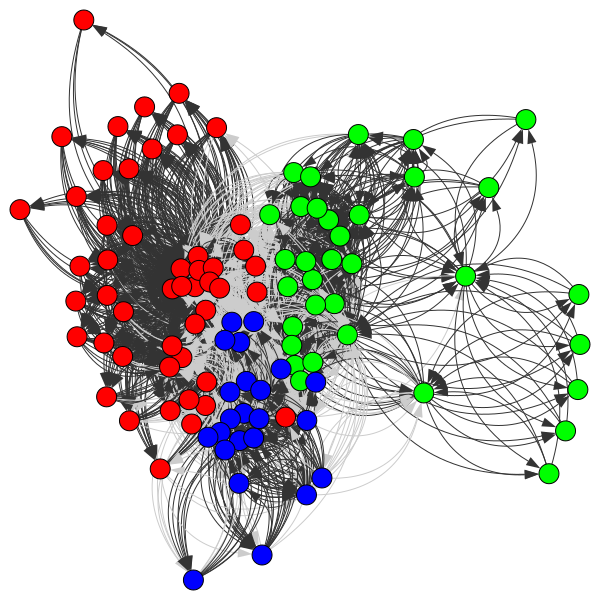

In [88]:
g2 = ig.Graph.Adjacency(AS.tolist())
partitions = louvain.find_partition(g2, louvain.ModularityVertexPartition)
# partitions = louvain.find_partition(g2, louvain.CPMVertexPartition, resolution_parameter = 0.02)
louvains_clus = [0]*len(AS)
idx=0
for part in partitions:
    for p in part:
        louvains_clus[p] = idx
    idx+=1
print(partitions)
ig.plot(partitions)

# Plotting all the SBMs from different methods and sources
1. The result of the paper
2. based on MCMC
3. The result of directly using igraph package
4. The result we get by running Louvain

In [51]:
rand_colors = []
for i in range(0, 50):
    rand_colors.append('%06X' % np.random.randint(0, 0xFFFFFF))

In [63]:
def _plot(g, membership=None, colors=rand_colors):
    if membership is not None:
        gcopy = g.copy()
        edges = []
        edges_colors = []
        for edge in g.es():
            if membership[edge.tuple[0]] != membership[edge.tuple[1]]:
                edges.append(edge)
                edges_colors.append("gray")
            else:
                edges_colors.append("black")
        gcopy.delete_edges(edges)
        layout = gcopy.layout("kk")
        g.es["color"] = edges_colors
    else:
        layout = g.layout("kk")
        g.es["color"] = "gray"
    visual_style = {}
    visual_style["vertex_label_dist"] = 0
    visual_style["vertex_shape"] = "circle"
    visual_style["edge_color"] = g.es["color"]
    # visual_style["bbox"] = (4000, 2500)
    visual_style["vertex_size"] = 15
    visual_style["layout"] = layout
    visual_style["bbox"] = (400, 400)
#     visual_style["margin"] = 30
    for vertex in g.vs():
        vertex["label"] = ''#vertex.index
    if membership is not None:
        for vertex in g.vs():
            vertex["color"] = str('#') + colors[membership[vertex.index]]
        visual_style["vertex_color"] = g.vs["color"]
    return ig.plot(g, **visual_style)

### Clusters from the paper

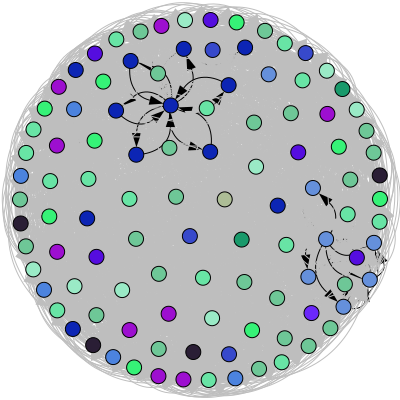

In [64]:
_plot(g2, chiMeta['Cluster'])

### Clusters using MCMC

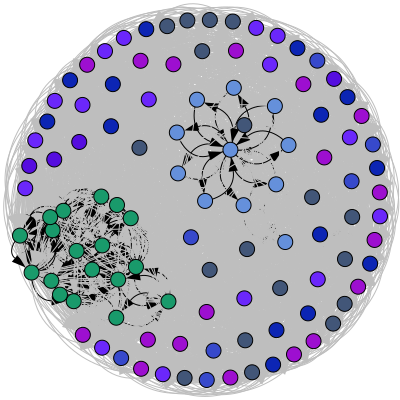

In [65]:
_plot(g2, blockAssignment)

### Clusters using the iGraph tool

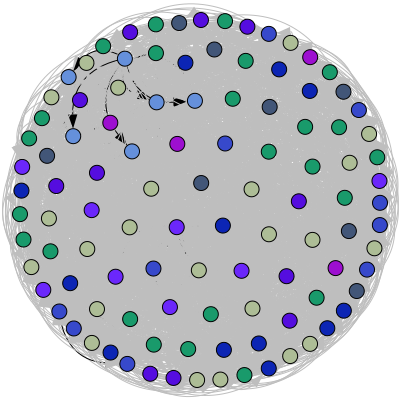

In [66]:
_plot(g2, blocks)

### Clusters using the louvain algorithm

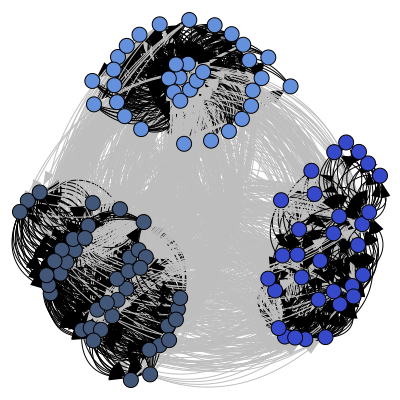

In [81]:
_plot(g2, louvains_clus)

# Regression Analysis
of the resulting blocks to show how predictable the labels are based on the species attributes, both in the case of labels provided in the paper and the labels we got running the SBM model

In [119]:
X = chiMeta[]
loo = LeaveOneOut()
loo.get_n_splits(X)


for train_index, test_index in loo.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]
   print(X_train, X_test, y_train, y_test)

regr = linear_model.LinearRegression()